<a href="https://colab.research.google.com/github/epadam/CNN_AV1/blob/master/training/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, sys, pickle, json
from os import makedirs
from os.path import exists, join
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

## Fetch data
Please go to the website : http://www.mediafire.com/folder/gsg1rom82enk1,q53dvilzsxqub,p7t6pb2pyab39,rhokuo26p6bjw,6v62mfqc4kzn9/shared 

the download link is changing all the time, choose download for the required file and go to the download page, then right click the botton to save the link then paste it below


In [82]:
import urllib.request
urllib.request.urlretrieve('http://download2266.mediafire.com/2etpg8m26geg/3nbgavkrz42h1d7/mergeanoS_samples_32_intra_uint8.txt', 'nine_pixel_32.txt')
urllib.request.urlretrieve('http://download2266.mediafire.com/aejts0dl7zbg/x66zhh8dsesfv6o/mergeanoS_labels_32_intra.txt', 'nine_labels_32.txt')
urllib.request.urlretrieve('http://download853.mediafire.com/0ywuydmakifg/xrnbs0zpjib1mme/mergeanoS_qps_32_intra.txt', 'nine_QPs_32.txt')

os.listdir()

['.config',
 'nine_pixel_32.txt',
 'undersampling_QPs_32.txt',
 'nine_labels_32.txt',
 'undersampling_labels_32.txt',
 'nine_QPs_32.txt',
 'undersampling_pixel_32.txt',
 'sample_data']

In [0]:
batch_size = 128
num_classes = 10
block_size = 32
NUM_CHANNELS = 1
epochs = 50

## Read samplse, labels and QPs

In [83]:
sample_file = 'nine_pixel_32.txt'
label_file = 'nine_labels_32.txt'
qp_file = 'nine_QPs_32.txt'

with open(sample_file, 'rb') as f:
    pixels = f.read()
    raw = np.frombuffer(pixels, dtype = np.uint8)
    raw = np.reshape(raw, [-1, block_size, block_size, NUM_CHANNELS])
    print(np.shape(raw))
    raw_train = raw[:len(raw)//100*90:]
    print(np.shape(raw_train))
    raw_test = raw[-len(raw)//100*10:]
    print(np.shape(raw_test))


with open(label_file, 'r') as f_single_label:
    single_label = f_single_label.read()    
    single_label =np.fromstring (single_label, dtype=np.uint8 ,sep=' ')
    single_label = np.reshape(single_label, [-1])
    y_test = single_label[-len(raw)//100*10:]
    labels=single_label
    single_label = keras.utils.to_categorical(single_label, num_classes)
    #print(np.shape(single_label))
    label_train = single_label[:len(raw)//100*90]
    label_test = single_label[-len(raw)//100*10:]
    print(np.shape(label_train))
    print(np.shape(label_test))


with open(qp_file, 'r') as f_qp:
    qps = f_qp.read()
    qps =np.fromstring (qps, dtype=np.uint8, sep=' ')
    qps = np.reshape(qps, [-1,1])
    #print(np.shape(qps))
    qp_train = qps[:len(raw)//100*90]
    qp_test = qps[-len(raw)//100*10:]
    print(np.shape(qp_train))
    print(np.shape(qp_test))


(41859, 32, 32, 1)
(37620, 32, 32, 1)
(4190, 32, 32, 1)
(37620, 10)
(4190, 10)
(37620, 1)
(4190, 1)


## Check how the samples look like

partition= Vert QP= 120


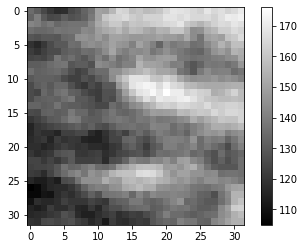

partition= Vert QP= 120


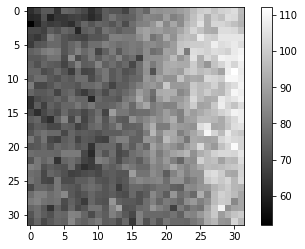

partition= Horz QP= 120


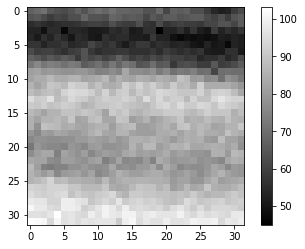

partition= Horz4 QP= 120


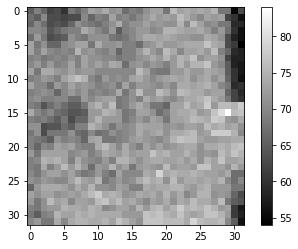

partition= Vert QP= 120


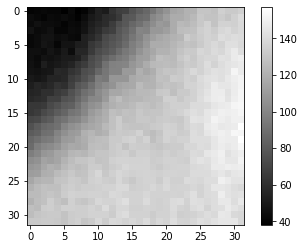

partition= Horz QP= 120


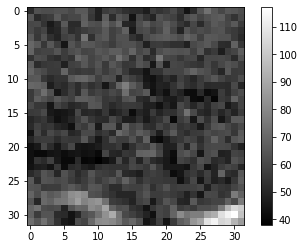

partition= Horz4 QP= 120


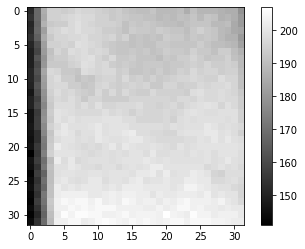

partition= VertB QP= 120


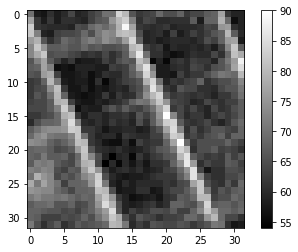

partition= Split QP= 120


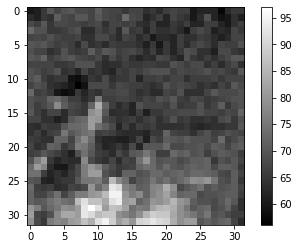

partition= None QP= 120


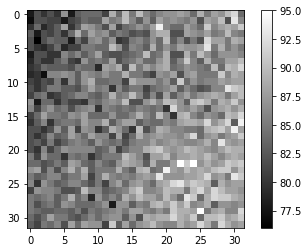

In [84]:
image = np.reshape(raw, [-1, block_size, block_size])
for i in range(10):
	mode=['None','Horz','Vert','Split','HorzA','HorzB','VertA','VertB','Horz4','Vert4']
	print('partition=', mode[labels[i+10]], 'QP=',qps[i+10,0])
	plt.imshow(image[i+10], cmap='gray')
	plt.colorbar()
	plt.show()

## Define the models, total 6 models

In [0]:
from tensorflow.keras import optimizers, backend
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Concatenate, Conv2D, MaxPooling2D, Lambda, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

In [0]:
# Normalize
def sub_mean(x):
    x = x/255
    x = x - backend.mean(x)   
    return x

def m1_64():

    data = Input(shape=(block_size,block_size,NUM_CHANNELS))

    data_norm = Lambda(sub_mean)(data)

    data_pooling = AveragePooling2D(pool_size=(4, 4),padding='valid')(data_norm)

    conv1 = Conv2D(16, (4, 4), strides =(4,4), activation='relu', padding='valid')(data_pooling)
    conv1_d = Dropout(0.5)(conv1)

    conv2 = Conv2D(24, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv1_d)
    conv2_d = Dropout(0.5)(conv2)
    flat2 = Flatten()(conv2_d)

    conv3 = Conv2D(32, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv2_d)
    conv3_d = Dropout(0.5)(conv3)
    flat3 = Flatten()(conv3_d)

    qp = Input(shape=(1,))
    qp_n = Lambda(lambda x: x/255)(qp)

    concat = Concatenate(axis=1)([flat2, flat3, qp_n])

    fc1 = Dense(64, activation='relu')(concat)
    fc1_d = Dropout(0.5)(fc1)
    fc1_qp = Concatenate(axis=1)([fc1_d, qp_n])

    fc2 = Dense(48, activation='relu')(fc1_qp)
    fc2_d = Dropout(0.5)(fc2)
    fc2_qp = Concatenate(axis=1)([fc2_d, qp_n])
    
    output = Dense(num_classes, activation='softmax')(fc2_qp)

    model = Model(inputs=[data,qp], outputs=output)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    
    return model


def m2_64():

    image = Input(shape=(block_size,block_size,NUM_CHANNELS))

    image_norm = Lambda(sub_mean)(image)

    #data_print=Lambda(lambda x: tf.Print(x[:,], [x], message='data', summarize=-1))(data_norm)
    data_pooling = AveragePooling2D(pool_size=(4, 4),padding='valid')(image_norm)

    conv1 = Conv2D(32, (3, 3), strides =(1,1),padding='valid', activation='relu')(data_pooling)
    #conv1_Norm = BatchNormalization()(conv1)
    conv1_dropout = Dropout(rate = 0.7)(conv1)

    conv2 = Conv2D(64, (3, 3), strides =(1,1), padding='valid', activation='relu')(conv1_dropout)
    #conv2_Norm = BatchNormalization()(conv2)
    conv2_dropout = Dropout(rate = 0.7)(conv2)
    
    pooling1 = MaxPooling2D(pool_size=(2, 2))(conv2_dropout)
   
    flat2 = Flatten()(pooling1)

    qp = Input(shape=(1,))
    qp_n = Lambda(lambda x: x/255)(qp)

    flat2_qp = Concatenate(axis=1)([flat2, qp_n])

    fc1 = Dense(128, activation='relu')(flat2_qp)
    fc1_d = Dropout(rate = 0.7)(fc1)

    fc1_qp = Concatenate(axis=1)([fc1_d, qp_n])

    output = Dense(num_classes, activation='softmax')(fc1_qp)

    model = Model(inputs=[image,qp], outputs=output)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])

    #plot_model(model, to_file='model_2.png', show_shapes=1)
    
    return model



def m1_32():

    data = Input(shape=(block_size,block_size,NUM_CHANNELS))

    data_norm = Lambda(sub_mean)(data)

    data_pooling = AveragePooling2D(pool_size=(2, 2),padding='valid')(data_norm)   

    conv1 = Conv2D(16, (4, 4), strides =(4,4),padding='valid', activation='relu')(data_pooling)
    conv1_d = Dropout(0.05)(conv1)

    conv2 = Conv2D(24, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv1_d)
    conv2_d = Dropout(0.05)(conv2)
    flat2 = Flatten()(conv2_d)

    conv3 = Conv2D(32, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv2_d)
    conv3_d = Dropout(0.05)(conv3)
    flat3 = Flatten()(conv3_d)

    qp = Input(shape=(1,))
    qp_n = Lambda(lambda x: x/255)(qp)

    concat = Concatenate(axis=1)([flat2, flat3, qp_n])

    fc1 = Dense(64, activation='relu')(concat)
    fc1_d = Dropout(0.05)(fc1)
    fc1_qp = Concatenate(axis=1)([fc1_d, qp_n])

    fc2 = Dense(48, activation='relu')(fc1_qp)
    fc2_d = Dropout(0.05)(fc2)
    fc2_qp = Concatenate(axis=1)([fc2_d, qp_n])

    output = Dense(num_classes, activation='softmax')(fc2_qp)

    model = Model(inputs=[data,qp], outputs=output)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    
    return model

def m2_32():

    image = Input(shape=(block_size,block_size,NUM_CHANNELS))

    image_norm = Lambda(sub_mean)(image)

    data_pooling = AveragePooling2D(pool_size=(2, 2),padding='valid')(image_norm)

    conv1 = Conv2D(32, (3, 3), strides =(1,1),padding='valid', activation='relu')(data_pooling)
    #conv1_Norm = BatchNormalization()(conv1)
    conv1_d = Dropout(rate = 0.5)(conv1)

    conv2 = Conv2D(64, (3, 3), strides =(1,1), padding='valid', activation='relu')(conv1_d)
    #conv2_Norm = BatchNormalization()(conv2)
    conv2_d = Dropout(rate = 0.5)(conv2)

    pooling1 = MaxPooling2D(pool_size=(2, 2))(conv2_d)

    flat2 = Flatten()(pooling1)

    qp = Input(shape=(1,))
    qp_n = Lambda(lambda x: x/255)(qp)

    flat2_qp = Concatenate(axis=1)([flat2, qp_n])

    fc1 = Dense(128, activation='relu')(flat2_qp)
    fc1_d = Dropout(rate = 0.7)(fc1)

    fc1_qp = Concatenate(axis=1)([fc1_d, qp_n])

    output = Dense(num_classes, activation='softmax')(fc1_qp)

    model = Model(inputs=[image,qp], outputs=output)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])

    
    return model

def m1_16():

    data = Input(shape=(block_size,block_size,NUM_CHANNELS))

    data_norm = Lambda(sub_mean)(data)

    conv1 = Conv2D(16, (4, 4), strides =(4,4),padding='valid', activation='relu')(data_norm)
    conv1_dropout = Dropout(rate=0.7)(conv1)
    #conv1_Norm = BatchNormalization()(conv1)

    conv2 = Conv2D(24, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv1_dropout)
    conv2_dropout = Dropout(rate=0.7)(conv2)
    #conv2_Norm = BatchNormalization()(conv2)
    flat2 = Flatten()(conv2_dropout)

    conv3 = Conv2D(32, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv2_dropout)
    conv3_dropout = Dropout(rate=0.7)(conv3)
    #conv3_Norm = BatchNormalization()(conv3)
    flat3 = Flatten()(conv3_dropout)

    qp = Input(shape=(1,))
    qp_n = Lambda(lambda x: x/255)(qp)

    concat = Concatenate(axis=1)([flat2, flat3, qp_n])

    
    fc1 = Dense(64, activation='relu')(concat)
    fc1_dropout = Dropout(rate=0.7)(fc1)
    fc1_qp = Concatenate(axis=1)([fc1_dropout, qp_n])

    fc2 = Dense(48, activation='relu')(fc1_qp)
    fc2_dropout = Dropout(rate=0.7)(fc2)
    fc2_qp = Concatenate(axis=1)([fc2_dropout, qp_n])

    output = Dense(num_classes, activation='softmax')(fc2_qp)

    model = Model(inputs=[data,qp], outputs=output)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])

    #plot_model(model, to_file='cnn_model.png', show_shapes=1)
    
    return model

def m2_16():

    data = Input(shape=(block_size,block_size,NUM_CHANNELS))

    data_norm = Lambda(sub_mean)(data)

    conv1 = Conv2D(32, (3, 3), strides =(1,1),padding='valid', activation='relu')(data_norm)
    conv1_dropout = Dropout(rate=0.5)(conv1)
 
    conv2 = Conv2D(64, (3, 3), strides =(1,1), activation='relu', padding='valid')(conv1_dropout)
    conv2_dropout = Dropout(rate=0.5)(conv2)

    pooling1 = MaxPooling2D(pool_size=(2, 2))(conv2_dropout)
    
    flat2 = Flatten()(pooling1)

    qp = Input(shape=(1,))
    qp_n = Lambda(lambda x: x/255)(qp)

    concat = Concatenate(axis=1)([flat2, qp_n])

    fc1 = Dense(128, activation='relu')(concat)
    fc1_d = Dropout(rate=0.5)(fc1)
    
    fc1_qp = Concatenate(axis=1)([fc1_d, qp_n])

    #fc2 = Dense(48, activation='relu')(fc1_qp)
    #fc2_qp = Concatenate(axis=1)([fc2, qp_n])

    output = Dense(num_classes, activation='softmax')(fc1_qp)

    model = Model(inputs=[data,qp], outputs=output)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    
    #plot_model(model, to_file='model.png')
    
    return model

  

## Choose block size and m1 or m2

In [87]:
model = m1_32()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, 32, 32, 1)    0           input_23[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_11 (AveragePo (None, 16, 16, 1)    0           lambda_22[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 4, 4, 16)     272         average_pooling2d_11[0][0]       
___________________________________________________________________________________________

In [88]:
history = model.fit([raw_train, qp_train], label_train, validation_data=([raw_test, qp_test], label_test), batch_size=batch_size, epochs=epochs, verbose=1)


Train on 37620 samples, validate on 4190 samples
Epoch 1/50
37620/37620 [==============================] - 4s 109us/sample - loss: 2.1804 - acc: 0.1495 - val_loss: 2.1218 - val_acc: 0.1883
Epoch 2/50
37620/37620 [==============================] - 3s 85us/sample - loss: 2.1035 - acc: 0.1958 - val_loss: 2.0509 - val_acc: 0.2193
Epoch 3/50
37620/37620 [==============================] - 3s 86us/sample - loss: 2.0586 - acc: 0.2250 - val_loss: 2.0076 - val_acc: 0.2492
Epoch 4/50
37620/37620 [==============================] - 3s 90us/sample - loss: 2.0182 - acc: 0.2490 - val_loss: 1.9786 - val_acc: 0.2733
Epoch 5/50
37620/37620 [==============================] - 3s 93us/sample - loss: 1.9914 - acc: 0.2626 - val_loss: 1.9554 - val_acc: 0.2804
Epoch 6/50
37620/37620 [==============================] - 4s 99us/sample - loss: 1.9751 - acc: 0.2685 - val_loss: 1.9594 - val_acc: 0.2754
Epoch 7/50
37620/37620 [==============================] - 4s 97us/sample - loss: 1.9616 - acc: 0.2764 - val_loss: 1.

## Plot the accuracy and precision

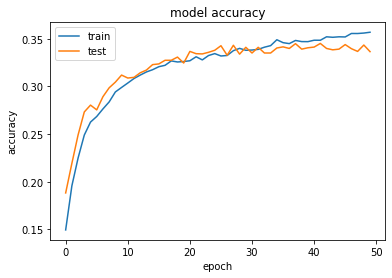

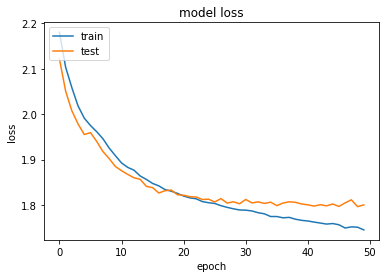

In [90]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Plot the confusion matrix

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # if not title:
    #     if normalize:
    #         title = 'Normalized confusion matrix'
    #     else:
    #         title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

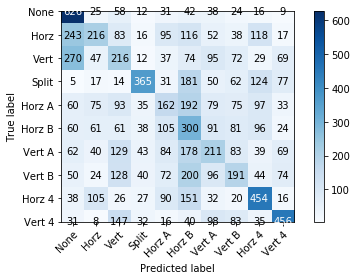

In [0]:
y_pred = model.predict([raw_test, qp_test])
y_index =np.zeros(len(y_pred))

for i in range(len(y_pred)):
    y_index[i] = np.argmax(y_pred[i])

y_test = y_test.astype(int)
y_index = y_index.astype(int)

class_names = ["None", "Horz", "Vert", "Split", "Horz A", "Horz B", "Vert A", "Vert B", "Horz 4", "Vert 4"]

plot_confusion_matrix(y_test, y_index, classes=class_names)
